In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import load_model
from numpy import concatenate
from pandas import DataFrame
from pandas import concat

#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

print(tf.__version__)

Couldn't import dot_parser, loading of dot files will not be possible.
2.2.0


Using TensorFlow backend.


In [2]:
df=pd.read_csv("data_sin_tipocambio.csv")
#df=pd.read_csv("data_sin_varnula.csv")
#df=pd.read_csv("data_complete.csv")
df.head()

,date,dow(USD),euro_stoxx50(USD),nasdaq(USD),nikkei(USD),oro(USD),petroleo(USD),shangai_stock_exchange(USD),sp_500(USD),BCHAIN-TOTBC,BCHAIN-AVBLS,BCHAIN-MIREV (USD),BCHAIN-HRATE,BCHAIN-NTRBL,BCHAIN-NADDU,eur_usd,cny_usd,gbp_usd,BCHAIN-MKPRU (USD)
0,2015-01-15,43.80,3112.370,45.670,16872.95,1380.00,48.60,4.12,2013.750,13727150.0,0.413363,761422.01,303832.201585,824.0,212403.0,1.1789,0.16140,1.5236,218.11
1,2015-01-16,43.26,3147.530,45.730,16812.96,1404.90,46.35,4.12,1992.250,13730725.0,0.382308,768009.00,325690.633354,731.0,219873.0,1.1633,0.16140,1.5185,205.35
2,2015-01-17,43.26,3147.530,45.730,16812.96,1342.95,47.65,4.12,1992.250,13734300.0,0.366155,677501.44,299460.515231,633.0,254267.0,1.1633,0.16140,1.5185,197.12
3,2015-01-18,43.26,3178.075,45.730,16906.87,1281.00,48.95,4.12,1992.250,13738025.0,0.330078,789179.66,325690.633354,703.0,223392.0,1.1592,0.16105,1.5177,211.18
4,2015-01-19,44.13,3208.620,46.165,17000.78,1279.40,48.84,4.12,2006.505,13741900.0,0.343386,826197.10,338805.692415,740.0,197559.0,1.1551,0.16070,1.5169,212.39


In [3]:
df.shape

(2177, 19)

## Graficamos el historial del bitcoin desde el 2018 hasta la fecha

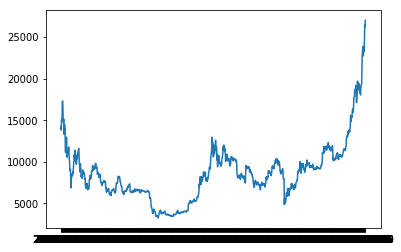

In [4]:
plt.plot(df.iloc[1082:,0], df.iloc[1082:,-1])

## Funcion para obtener ventanas a partir del dataframe (hay que pensar si nos lo rapiñamos o solo decimos de donde lo sacamos)

In [5]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
    Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        # shift
        # se utiliza para desplazar el índice de DataFrame por un número 
        # determinado de períodos con una frecuencia de tiempo opcional
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Definimos los  hiperparemetros y estandarizamos nuestros datos

In [6]:
ventana=3 # Se puede mover 
n_cols = df.shape[1] - 1 # Numero de variables incluyendo la variable objetivo
entrenamiento=800 #Cuantos dias de entrenamiento (restante sera para el conjunto test)
n_obs=ventana*n_cols

In [7]:

values = df.iloc[1082:,1:].values# Desde el primer dia del 2018

transformer = StandardScaler()
transformer.fit(values)

transformer_y = StandardScaler()
transformer_y.fit(df.iloc[1082:,-1].values.reshape(-1,1))

values = transformer.transform(values)
data = series_to_supervised(values, ventana,1 )

### Visualizamos el data frame de ventanas

In [8]:
data.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var10(t-3),...,var9(t),var10(t),var11(t),var12(t),var13(t),var14(t),var15(t),var16(t),var17(t),var18(t)
3,1.161484,0.866946,-1.378602,0.528529,-1.038526,0.499388,0.477602,-0.718423,-1.813396,-0.066545,...,-1.802392,0.077947,4.423236,-1.540261,1.341660,3.707375,1.592327,2.050074,1.638374,1.820202
4,1.161484,1.061030,-1.266617,0.672790,-0.380414,0.849897,0.860906,-0.496031,-1.809849,-0.034426,...,-1.798572,0.079569,4.932414,-1.512628,1.359982,4.799380,1.452283,2.040704,1.638374,1.861608
5,1.161484,0.275754,-1.222589,-0.219471,-0.565139,0.599867,0.035328,-0.849727,-1.805961,-0.044657,...,-1.795321,0.088724,4.765112,-1.575431,1.045032,3.249554,0.530629,1.684610,0.667067,2.421299
6,1.161484,0.500245,-0.998939,-0.040272,-0.564194,0.872874,0.035328,-0.974776,-1.802392,0.077947,...,-1.791501,0.022579,5.696160,-1.512628,0.429209,3.256040,0.530629,0.803748,0.486651,2.462417
7,1.161484,0.724736,-0.775289,0.138927,-0.563249,1.145881,-0.230036,-1.099826,-1.798572,0.079569,...,-1.787818,-0.012308,5.159285,-1.527701,0.752450,3.450862,0.530629,-0.077115,0.306236,2.273169


### Creamos nuestro conjunto train y test con sus respectivos X y Y variables

In [9]:
train=data.iloc[:entrenamiento,:]
test =data.iloc[entrenamiento:,:]

train_X, train_y = train.iloc[:, :n_obs].values, train.iloc[:, -1].values
test_X, test_y = test.iloc[:, :n_obs].values, test.iloc[:, -1].values

print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

(800, 54) (800,)
(292, 54) (292,)


### Modificamos las dimensiones del train y test para que tengan un formato:
(muestras, ventana, numero de variables)

In [10]:
train_X = train_X.reshape((train_X.shape[0], ventana, n_cols))
test_X = test_X.reshape((test_X.shape[0], ventana, n_cols))

## Creacion del modelo

In [11]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
   tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                       strides=1, padding="causal",
                       activation="relu",
                       input_shape=[train_X.shape[1],train_X.shape[2]]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(50,activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 10.0)
])


model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),metrics=["mae"])
history = model.fit(train_X,train_y,shuffle=False,validation_data=(test_X,test_y),epochs=1000)

Epoch 1/1000
25/25 [==============================] - 2s 71ms/step - loss: 0.3408 - mae: 0.6895 - val_loss: 0.6178 - val_mae: 0.9891
Epoch 2/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.3339 - mae: 0.6816 - val_loss: 0.6185 - val_mae: 0.9902
Epoch 3/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.3326 - mae: 0.6842 - val_loss: 0.6192 - val_mae: 0.9913
Epoch 4/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.3286 - mae: 0.6717 - val_loss: 0.6199 - val_mae: 0.9923
Epoch 5/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.3264 - mae: 0.6722 - val_loss: 0.6206 - val_mae: 0.9934
Epoch 6/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.3267 - mae: 0.6754 - val_loss: 0.6212 - val_mae: 0.9943
Epoch 7/1000
25/25 [==============================] - 0s 14ms/step - loss: 0.3306 - mae: 0.6769 - val_loss: 0.6218 - val_mae: 0.9952
Epoch 8/1000
25/25 [==============================] - 0s 14ms/step - loss

25/25 [==============================] - 0s 7ms/step - loss: 0.2669 - mae: 0.5918 - val_loss: 0.6425 - val_mae: 1.0278
Epoch 63/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.2609 - mae: 0.5826 - val_loss: 0.6427 - val_mae: 1.0281
Epoch 64/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.2541 - mae: 0.5718 - val_loss: 0.6428 - val_mae: 1.0284
Epoch 65/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.2606 - mae: 0.5769 - val_loss: 0.6431 - val_mae: 1.0287
Epoch 66/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.2585 - mae: 0.5766 - val_loss: 0.6432 - val_mae: 1.0290
Epoch 67/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.2563 - mae: 0.5726 - val_loss: 0.6433 - val_mae: 1.0292
Epoch 68/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.2550 - mae: 0.5729 - val_loss: 0.6435 - val_mae: 1.0296
Epoch 69/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.2518 -

25/25 [==============================] - 0s 8ms/step - loss: 0.2182 - mae: 0.5232 - val_loss: 0.6441 - val_mae: 1.0337
Epoch 124/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.2168 - mae: 0.5199 - val_loss: 0.6440 - val_mae: 1.0337
Epoch 125/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.2178 - mae: 0.5210 - val_loss: 0.6438 - val_mae: 1.0336
Epoch 126/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.2169 - mae: 0.5209 - val_loss: 0.6438 - val_mae: 1.0335
Epoch 127/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.2097 - mae: 0.5142 - val_loss: 0.6437 - val_mae: 1.0335
Epoch 128/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.2120 - mae: 0.5133 - val_loss: 0.6436 - val_mae: 1.0334
Epoch 129/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.2130 - mae: 0.5154 - val_loss: 0.6435 - val_mae: 1.0334
Epoch 130/1000
25/25 [==============================] - 0s 7ms/step - loss: 0

25/25 [==============================] - 0s 10ms/step - loss: 0.1916 - mae: 0.4866 - val_loss: 0.6333 - val_mae: 1.0232
Epoch 185/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.1851 - mae: 0.4825 - val_loss: 0.6330 - val_mae: 1.0229
Epoch 186/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.1807 - mae: 0.4687 - val_loss: 0.6328 - val_mae: 1.0226
Epoch 187/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.1854 - mae: 0.4782 - val_loss: 0.6325 - val_mae: 1.0222
Epoch 188/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.1807 - mae: 0.4713 - val_loss: 0.6321 - val_mae: 1.0219
Epoch 189/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.1798 - mae: 0.4720 - val_loss: 0.6319 - val_mae: 1.0215
Epoch 190/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.1744 - mae: 0.4696 - val_loss: 0.6316 - val_mae: 1.0212
Epoch 191/1000
25/25 [==============================] - 0s 7ms/step - loss: 

25/25 [==============================] - 0s 8ms/step - loss: 0.1556 - mae: 0.4391 - val_loss: 0.6139 - val_mae: 1.0005
Epoch 246/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.1558 - mae: 0.4374 - val_loss: 0.6135 - val_mae: 1.0000
Epoch 247/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.1531 - mae: 0.4327 - val_loss: 0.6131 - val_mae: 0.9996
Epoch 248/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.1511 - mae: 0.4309 - val_loss: 0.6127 - val_mae: 0.9991
Epoch 249/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.1570 - mae: 0.4425 - val_loss: 0.6124 - val_mae: 0.9987
Epoch 250/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.1556 - mae: 0.4371 - val_loss: 0.6121 - val_mae: 0.9983
Epoch 251/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.1535 - mae: 0.4336 - val_loss: 0.6118 - val_mae: 0.9980
Epoch 252/1000
25/25 [==============================] - 0s 7ms/step - loss: 0

25/25 [==============================] - 0s 8ms/step - loss: 0.1324 - mae: 0.4031 - val_loss: 0.5911 - val_mae: 0.9725
Epoch 307/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.1279 - mae: 0.3956 - val_loss: 0.5907 - val_mae: 0.9720
Epoch 308/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.1343 - mae: 0.4061 - val_loss: 0.5903 - val_mae: 0.9715
Epoch 309/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.1305 - mae: 0.4000 - val_loss: 0.5899 - val_mae: 0.9710
Epoch 310/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.1325 - mae: 0.4080 - val_loss: 0.5895 - val_mae: 0.9705
Epoch 311/1000
25/25 [==============================] - 0s 13ms/step - loss: 0.1324 - mae: 0.4069 - val_loss: 0.5891 - val_mae: 0.9700
Epoch 312/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.1299 - mae: 0.4047 - val_loss: 0.5886 - val_mae: 0.9694
Epoch 313/1000
25/25 [==============================] - 0s 7ms/step - loss: 

25/25 [==============================] - 0s 8ms/step - loss: 0.1180 - mae: 0.3842 - val_loss: 0.5672 - val_mae: 0.9423
Epoch 368/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.1143 - mae: 0.3751 - val_loss: 0.5669 - val_mae: 0.9419
Epoch 369/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.1188 - mae: 0.3839 - val_loss: 0.5664 - val_mae: 0.9413
Epoch 370/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.1085 - mae: 0.3665 - val_loss: 0.5660 - val_mae: 0.9408
Epoch 371/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.1161 - mae: 0.3800 - val_loss: 0.5656 - val_mae: 0.9403
Epoch 372/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.1158 - mae: 0.3813 - val_loss: 0.5652 - val_mae: 0.9397
Epoch 373/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.1133 - mae: 0.3740 - val_loss: 0.5648 - val_mae: 0.9392
Epoch 374/1000
25/25 [==============================] - 0s 9ms/step - loss: 0

25/25 [==============================] - 0s 7ms/step - loss: 0.0975 - mae: 0.3515 - val_loss: 0.5426 - val_mae: 0.9108
Epoch 429/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0945 - mae: 0.3496 - val_loss: 0.5422 - val_mae: 0.9103
Epoch 430/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0970 - mae: 0.3457 - val_loss: 0.5418 - val_mae: 0.9097
Epoch 431/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0986 - mae: 0.3518 - val_loss: 0.5413 - val_mae: 0.9092
Epoch 432/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0965 - mae: 0.3426 - val_loss: 0.5409 - val_mae: 0.9086
Epoch 433/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0949 - mae: 0.3410 - val_loss: 0.5405 - val_mae: 0.9081
Epoch 434/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.0981 - mae: 0.3508 - val_loss: 0.5401 - val_mae: 0.9076
Epoch 435/1000
25/25 [==============================] - 0s 11ms/step - loss: 

25/25 [==============================] - 0s 7ms/step - loss: 0.0859 - mae: 0.3289 - val_loss: 0.5188 - val_mae: 0.8802
Epoch 490/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0861 - mae: 0.3297 - val_loss: 0.5184 - val_mae: 0.8796
Epoch 491/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0836 - mae: 0.3233 - val_loss: 0.5180 - val_mae: 0.8791
Epoch 492/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0898 - mae: 0.3321 - val_loss: 0.5176 - val_mae: 0.8786
Epoch 493/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0854 - mae: 0.3224 - val_loss: 0.5172 - val_mae: 0.8780
Epoch 494/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0850 - mae: 0.3249 - val_loss: 0.5168 - val_mae: 0.8776
Epoch 495/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0860 - mae: 0.3228 - val_loss: 0.5165 - val_mae: 0.8771
Epoch 496/1000
25/25 [==============================] - 0s 7ms/step - loss: 0

25/25 [==============================] - 0s 11ms/step - loss: 0.0735 - mae: 0.3066 - val_loss: 0.4962 - val_mae: 0.8505
Epoch 551/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0780 - mae: 0.3170 - val_loss: 0.4959 - val_mae: 0.8501
Epoch 552/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0724 - mae: 0.2975 - val_loss: 0.4956 - val_mae: 0.8497
Epoch 553/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0731 - mae: 0.2978 - val_loss: 0.4953 - val_mae: 0.8493
Epoch 554/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0717 - mae: 0.2998 - val_loss: 0.4950 - val_mae: 0.8489
Epoch 555/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0747 - mae: 0.3069 - val_loss: 0.4946 - val_mae: 0.8484
Epoch 556/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0697 - mae: 0.2930 - val_loss: 0.4943 - val_mae: 0.8479
Epoch 557/1000
25/25 [==============================] - 0s 7ms/step - loss: 

25/25 [==============================] - 0s 16ms/step - loss: 0.0635 - mae: 0.2810 - val_loss: 0.4764 - val_mae: 0.8245
Epoch 612/1000
25/25 [==============================] - 0s 12ms/step - loss: 0.0605 - mae: 0.2730 - val_loss: 0.4761 - val_mae: 0.8241
Epoch 613/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0632 - mae: 0.2763 - val_loss: 0.4759 - val_mae: 0.8238
Epoch 614/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0627 - mae: 0.2755 - val_loss: 0.4757 - val_mae: 0.8235
Epoch 615/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0680 - mae: 0.2902 - val_loss: 0.4754 - val_mae: 0.8232
Epoch 616/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0642 - mae: 0.2818 - val_loss: 0.4751 - val_mae: 0.8228
Epoch 617/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0644 - mae: 0.2794 - val_loss: 0.4748 - val_mae: 0.8224
Epoch 618/1000
25/25 [==============================] - 0s 7ms/step - loss:

25/25 [==============================] - 0s 7ms/step - loss: 0.0515 - mae: 0.2494 - val_loss: 0.4593 - val_mae: 0.8023
Epoch 673/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0546 - mae: 0.2572 - val_loss: 0.4590 - val_mae: 0.8019
Epoch 674/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0565 - mae: 0.2593 - val_loss: 0.4587 - val_mae: 0.8015
Epoch 675/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0551 - mae: 0.2610 - val_loss: 0.4585 - val_mae: 0.8013
Epoch 676/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0570 - mae: 0.2665 - val_loss: 0.4582 - val_mae: 0.8010
Epoch 677/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0527 - mae: 0.2533 - val_loss: 0.4580 - val_mae: 0.8007
Epoch 678/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0555 - mae: 0.2601 - val_loss: 0.4577 - val_mae: 0.8004
Epoch 679/1000
25/25 [==============================] - 0s 7ms/step - loss: 0

25/25 [==============================] - 0s 7ms/step - loss: 0.0498 - mae: 0.2422 - val_loss: 0.4439 - val_mae: 0.7827
Epoch 734/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0474 - mae: 0.2404 - val_loss: 0.4436 - val_mae: 0.7824
Epoch 735/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.0461 - mae: 0.2383 - val_loss: 0.4434 - val_mae: 0.7821
Epoch 736/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0472 - mae: 0.2395 - val_loss: 0.4431 - val_mae: 0.7818
Epoch 737/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0462 - mae: 0.2376 - val_loss: 0.4428 - val_mae: 0.7814
Epoch 738/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0470 - mae: 0.2403 - val_loss: 0.4426 - val_mae: 0.7810
Epoch 739/1000
25/25 [==============================] - 0s 9ms/step - loss: 0.0482 - mae: 0.2430 - val_loss: 0.4423 - val_mae: 0.7807
Epoch 740/1000
25/25 [==============================] - 0s 7ms/step - loss: 0

25/25 [==============================] - 0s 7ms/step - loss: 0.0445 - mae: 0.2263 - val_loss: 0.4300 - val_mae: 0.7657
Epoch 795/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0418 - mae: 0.2256 - val_loss: 0.4298 - val_mae: 0.7654
Epoch 796/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0428 - mae: 0.2291 - val_loss: 0.4296 - val_mae: 0.7651
Epoch 797/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0419 - mae: 0.2253 - val_loss: 0.4293 - val_mae: 0.7648
Epoch 798/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0409 - mae: 0.2220 - val_loss: 0.4292 - val_mae: 0.7646
Epoch 799/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0409 - mae: 0.2251 - val_loss: 0.4289 - val_mae: 0.7643
Epoch 800/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0427 - mae: 0.2266 - val_loss: 0.4287 - val_mae: 0.7641
Epoch 801/1000
25/25 [==============================] - 0s 7ms/step - loss: 0

25/25 [==============================] - 0s 9ms/step - loss: 0.0375 - mae: 0.2160 - val_loss: 0.4191 - val_mae: 0.7529
Epoch 856/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0385 - mae: 0.2143 - val_loss: 0.4188 - val_mae: 0.7524
Epoch 857/1000
25/25 [==============================] - 0s 11ms/step - loss: 0.0376 - mae: 0.2132 - val_loss: 0.4185 - val_mae: 0.7521
Epoch 858/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0392 - mae: 0.2169 - val_loss: 0.4184 - val_mae: 0.7520
Epoch 859/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0361 - mae: 0.2092 - val_loss: 0.4182 - val_mae: 0.7518
Epoch 860/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0400 - mae: 0.2179 - val_loss: 0.4181 - val_mae: 0.7517
Epoch 861/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0375 - mae: 0.2155 - val_loss: 0.4179 - val_mae: 0.7514
Epoch 862/1000
25/25 [==============================] - 0s 7ms/step - loss:

25/25 [==============================] - 0s 7ms/step - loss: 0.0367 - mae: 0.2131 - val_loss: 0.4097 - val_mae: 0.7424
Epoch 917/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0354 - mae: 0.2092 - val_loss: 0.4095 - val_mae: 0.7422
Epoch 918/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0346 - mae: 0.2056 - val_loss: 0.4092 - val_mae: 0.7419
Epoch 919/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0323 - mae: 0.1961 - val_loss: 0.4090 - val_mae: 0.7416
Epoch 920/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0364 - mae: 0.2070 - val_loss: 0.4087 - val_mae: 0.7412
Epoch 921/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0356 - mae: 0.2030 - val_loss: 0.4086 - val_mae: 0.7411
Epoch 922/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0344 - mae: 0.2039 - val_loss: 0.4084 - val_mae: 0.7409
Epoch 923/1000
25/25 [==============================] - 0s 7ms/step - loss: 0

25/25 [==============================] - 0s 7ms/step - loss: 0.0316 - mae: 0.1975 - val_loss: 0.3998 - val_mae: 0.7303
Epoch 978/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0340 - mae: 0.2010 - val_loss: 0.3996 - val_mae: 0.7302
Epoch 979/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0322 - mae: 0.1959 - val_loss: 0.3995 - val_mae: 0.7300
Epoch 980/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0329 - mae: 0.1982 - val_loss: 0.3994 - val_mae: 0.7299
Epoch 981/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0286 - mae: 0.1841 - val_loss: 0.3993 - val_mae: 0.7299
Epoch 982/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0304 - mae: 0.1937 - val_loss: 0.3989 - val_mae: 0.7293
Epoch 983/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0331 - mae: 0.1996 - val_loss: 0.3988 - val_mae: 0.7292
Epoch 984/1000
25/25 [==============================] - 0s 7ms/step - loss: 0

## Graficamos la funcion de perdida del trainning vs el test

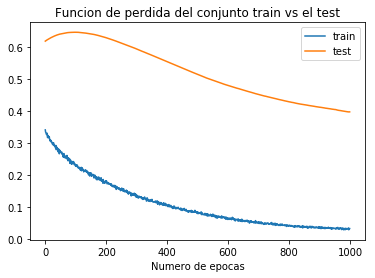

In [12]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title("Funcion de perdida del conjunto train vs el test")
plt.xlabel("Numero de epocas")
plt.show()


### Predecimos el test y lo graficamos con respecto al valor real

In [13]:
y_pred=model.predict(test_X)
y_pred_inv=transformer_y.inverse_transform(y_pred)# Transformamos a la escala real de los datos

Text(0.5,0,'Numero de dias')

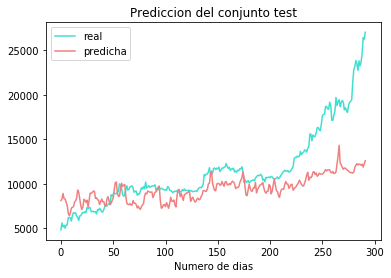

In [14]:
plt.plot(range(0,len(test_X)),df.iloc[-len(test_X):,-1],color="turquoise",label="real")
plt.plot(range(0,len(test_X)),y_pred_inv, color="lightcoral",label="predicha")
plt.legend()
plt.title("Prediccion del conjunto test")
plt.xlabel("Numero de dias")

### Predecimos el train y lo graficamos con respecto al valor real

In [15]:
y_pred_t=model.predict(train_X)
y_pred_inv_t=transformer_y.inverse_transform(y_pred_t)# Transformamos a la escala real de los datos

Text(0.5,0,'Numero de dias')

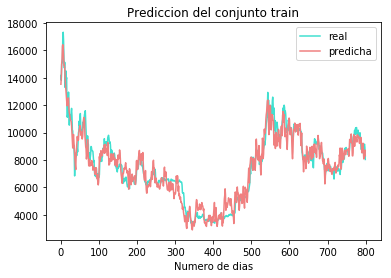

In [16]:
plt.plot(range(0,len(train_X)),df.iloc[1082:1082+len(train_X),-1],color="turquoise",label="real")
plt.plot(range(0,len(train_X)),y_pred_inv_t, color="lightcoral",label="predicha")
plt.legend()
plt.title("Prediccion del conjunto train")
plt.xlabel("Numero de dias")

In [17]:
 #model.save('modelo_3-norm.h5')

In [18]:
#model=load_model("modelo_3-norm.h5")

In [19]:
# loss: 0.0235 - mae: 0.1674 - val_loss: 0.3506 - val_mae: 0.6643
# ventana: 3
# epocas: 1000
# tasa: 1e-6
# lambda: 10.0
# Dropout: 0.2
# entrenamiento: 800
# df: data_sin_tipocambio
#model.save('modelo_4-norm.h5')